# Rotated Knife-Edge Measurements

**Ryan Robinson**

**Oct 2023**

---

The moving knife-edge method is one of three alternative methods for measuring beam width in ISO/TR 11146-3.

The technique involves physically blocking a portion of the laser beam using a sharp-edged obstruction, often referred to as a "knife-edge."

Traditionally knife edge measurements would only measure in either the x or y axis; however, knife-edge measurements can be adapted to characterize laser beams that are tilted or inclined with respect to the knife-edge. In such cases, the knife-edge can be oriented at an angle to match the tilt of the laser beam. This allows for the characterization of the laser beam's spatial intensity profile along the tilted axis.

# Knife-edge for a non-rotated beam

---

Lets first look at how beam_size and plot_image_analysis would report this beam.

The center of the beam ellipse is at (1328, 996)
The ellipse diameter (closest to horizontal) is 411 pixels
The ellipse diameter (closest to   vertical) is 1143 pixels
The ellipse is rotated 0° ccw from the horizontal


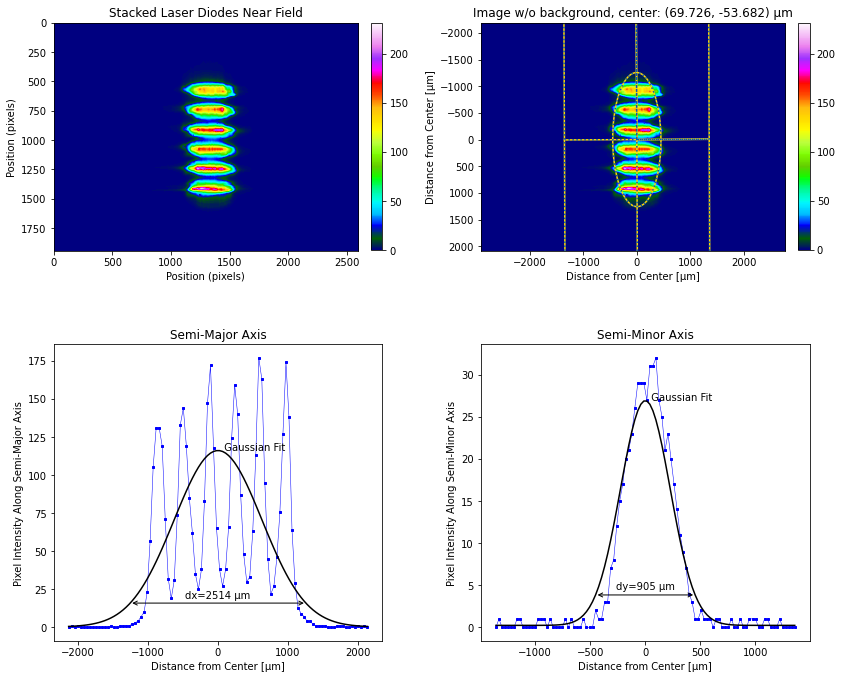

In [92]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import from this directory so we can rapidly test
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

def load_img(file, folder = r'../tests/test_beam_profiles/DAS'):
    """ Load an image into an array """
    full_path = folder + '/' + file
    if os.path.isfile(full_path):
        iobj = Image.open(full_path)
        img = np.asarray(iobj)
        return img
    else:
        print("No file found under:")
        print(full_path)
        return None

img = load_img('nf_100_1234.bmp')

x, y, dx, dy, phi = lbs.beam_size(img)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

lbs.plot_image_analysis(img, pixel_size=2.2, title="Stacked Laser Diodes Near Field")
plt.show()

# Example Of Knife-Edging
---
The below figures show a knife edge measurement in a few discrete increments.

The fractional range is from `-3*dx` to `3*dx` (or `dy` depending on dir).

## Knife-Edging In Y Direction:

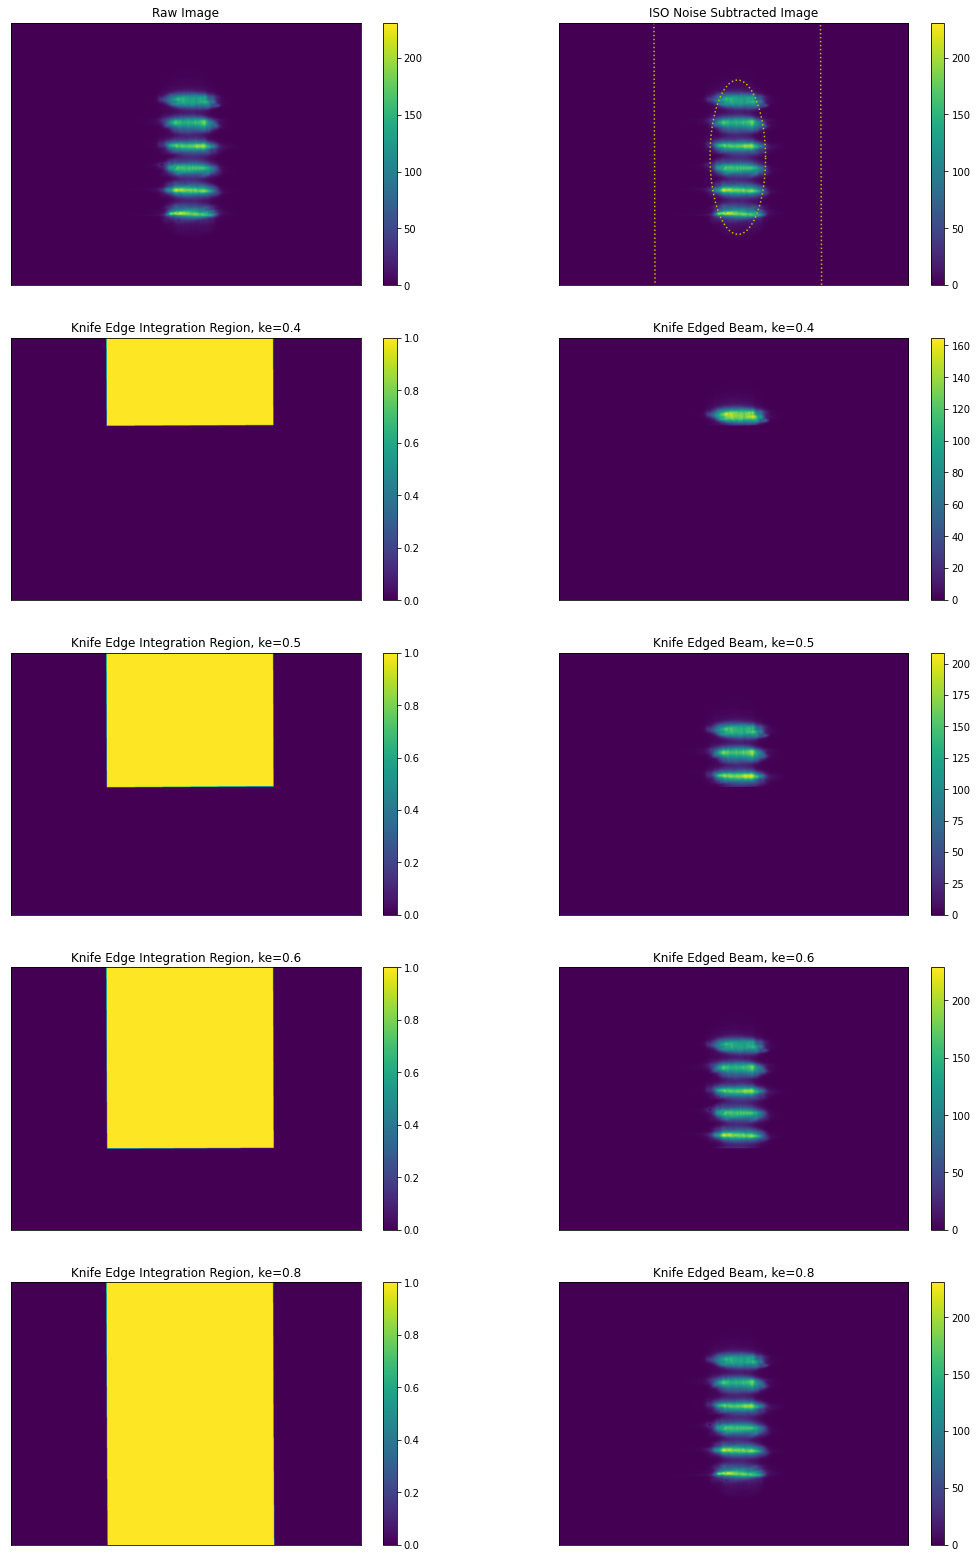

In [2]:

import numpy as np
import time

# Load image
img = load_img('nf_100_1234.bmp')

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create subplots
plt.subplots(5,2,figsize=(18,28))

# Plot Raw Image
# -------------------------------------------------------------------------------------------- #

plt.subplot(5,2,1)
plt.imshow(img)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Raw Image')

# Plot ISO Noise Subtracted Image
# -------------------------------------------------------------------------------------------- #

# Create an image with a subtracted background
wimg = lbs.subtract_iso_background(img)

# Generate plots
plt.subplot(5,2,2)
plt.imshow(wimg)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('ISO Noise Subtracted Image')

# Plot masks
xp,yp = lbs.rotated_rect_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

xp,yp = lbs.ellipse_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

# Limit plot size
vv, hh = wimg.shape
plt.xlim(0, hh)
plt.ylim(vv, 0)

# Knife Edge ke = 0.25
# -------------------------------------------------------------------------------------------- #

def ke_plot(ke, i):
    """ Method to generate figures for knife edge images """

    plt.subplot(5,2,i)

    mask = lbs.knife_edge_mask(wimg, x, y, dx, dy, phi, ke, dir = 'y')

    plt.imshow(mask)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edge Integration Region, ke={}'.format(ke))

    mwimg= np.copy(wimg)
    mwimg[mask < 1] = 0       # zero all values outside mask

    plt.subplot(5,2,i+1)
    plt.imshow(mwimg)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edged Beam, ke={}'.format(ke))

# -------------------------------------------------------------------------------------------- #

# Generate knife edge figures
ke_plot(0.4, 3)
ke_plot(0.5, 5)
ke_plot(0.6, 7)
ke_plot(0.8, 9)

### Knife-Edge Plots For Y Traversal:

Took 7.035 seconds to run measurement with 200 points
Beam widths:
[1277.60627037 2146.91933972]
869.313069351351


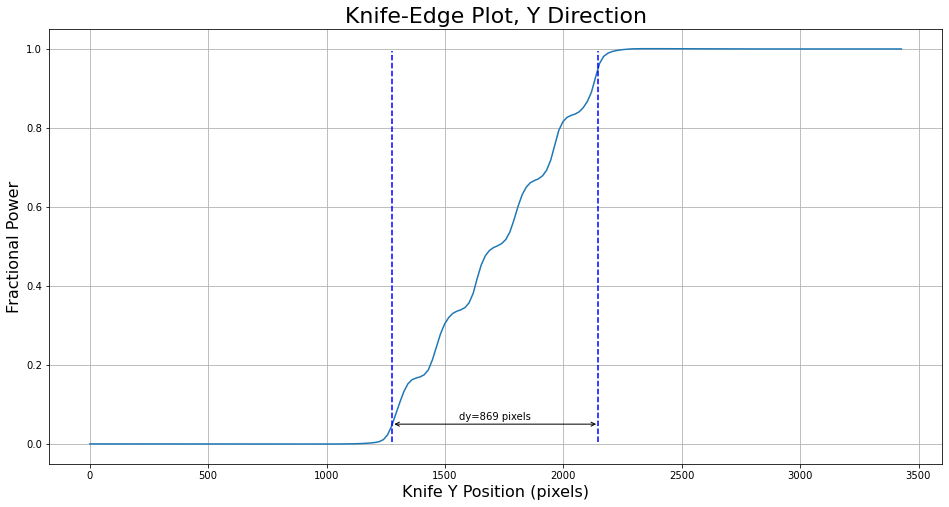

In [3]:
# Load image
img = load_img('nf_100_1234.bmp')

# Subtract background
wimg = lbs.subtract_iso_background(img)

# Mask beam
mask = lbs.rotated_rect_mask(wimg, x, y, dx, dy, phi)

# Working image
mwimg = np.copy(wimg)

# Apply mask
mwimg[mask < 0] = 0

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create array
x_axis = np.linspace(0,1,200)
y_axis = np.full_like(x_axis, 0.0)

# Start time
time1 = time.time()

# Knife edge direction
dir = 'y'

# Collect knife-edge data
for i, x_val in enumerate(x_axis):
    mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = dir)
    masked_image = np.copy(mwimg)
    masked_image[mask < 1] = 0
    y_axis[i] = np.sum(masked_image)

# Normalize knife edge
y_axis = y_axis/np.max(y_axis)

# End time
time2 = time.time()

# Plotting
# -------------------------------------------------------------------------------------------- #

# Convert x axis to pixels
x_axis_p = x_axis * dy * 3

plt.figure(2, figsize=(16,8))
plt.title("Knife-Edge Plot, Y Direction", fontsize = 22)
plt.xlabel("Knife Y Position (pixels)", fontsize=16)
plt.ylabel("Fractional Power", fontsize = 16)
plt.plot(x_axis_p, y_axis)
plt.grid('on')

# Print time information
print("Took {:.3f} seconds to run measurement with {} points".format(time2-time1, len(x_axis)))

# Find beam width using 5-95 knife-edge measurement
ke1 = 0.05
ke2 = 0.95

# Interpolate values
bws = np.interp([ke1, ke2], y_axis, x_axis_p)

print("Beam widths:")
print(bws)
print(bws[1]-bws[0])

# Plot points
# plt.plot(bws, [ke1,ke2], marker="o", markersize=10, linestyle='None') #, markeredgecolor="red", markerfacecolor="green")

# Plot lines
plt.axvline(x=bws[0], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke1*100), ls='--')
plt.axvline(x=bws[1], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke2*100), ls='--')

# Show distance on plot
units = 'pixels'
plt.annotate('', (bws[0], ke1), (bws[1], ke1), arrowprops={'arrowstyle': '<->'})
plt.text(np.average(bws), 1.1 * ke1, 'd%s=%.0f %s' % (dir, bws[1]-bws[0], units), va='bottom', ha='center')

# Show plots
plt.show()

## Knife-Edging In X Direction

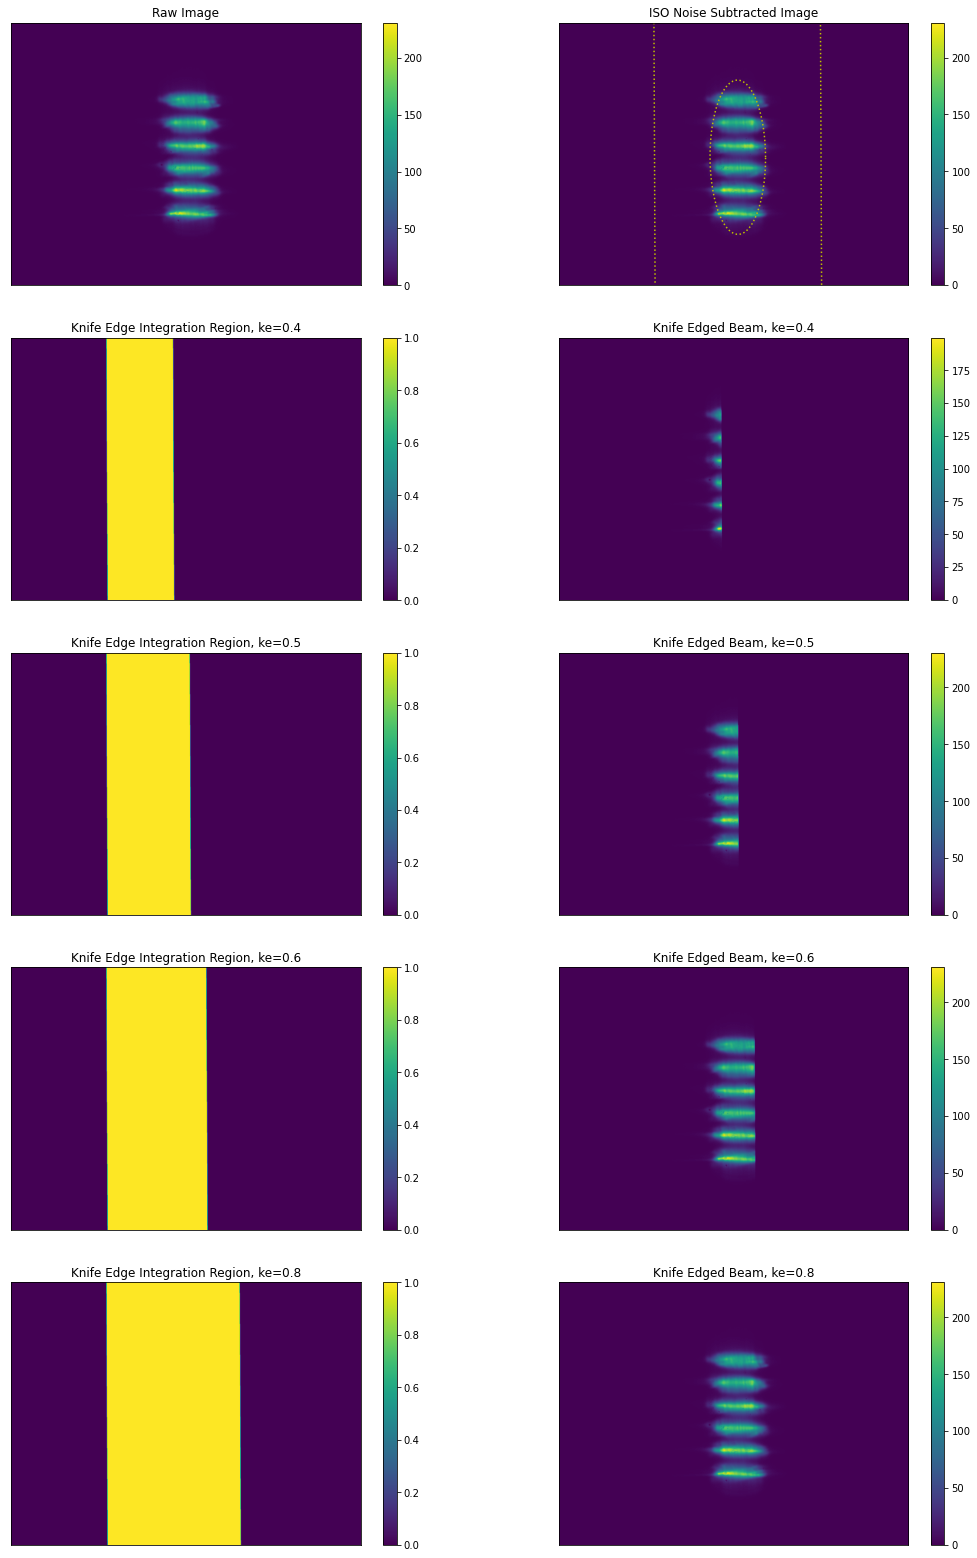

In [4]:

import numpy as np
import time

# Load image
img = load_img('nf_100_1234.bmp')

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create subplots
plt.subplots(5,2,figsize=(18,28))

# Plot Raw Image
# -------------------------------------------------------------------------------------------- #

plt.subplot(5,2,1)
plt.imshow(img)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Raw Image')

# Plot ISO Noise Subtracted Image
# -------------------------------------------------------------------------------------------- #

# Create an image with a subtracted background
wimg = lbs.subtract_iso_background(img)

# Generate plots
plt.subplot(5,2,2)
plt.imshow(wimg)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('ISO Noise Subtracted Image')

# Plot masks
xp,yp = lbs.rotated_rect_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

xp,yp = lbs.ellipse_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

# Limit plot size
vv, hh = wimg.shape
plt.xlim(0, hh)
plt.ylim(vv, 0)

# Knife Edge ke = 0.25
# -------------------------------------------------------------------------------------------- #

def ke_plot(ke, i):
    """ Method to generate figures for knife edge images """

    plt.subplot(5,2,i)

    mask = lbs.knife_edge_mask(wimg, x, y, dx, dy, phi, ke, dir = 'x')

    plt.imshow(mask)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edge Integration Region, ke={}'.format(ke))

    mwimg= np.copy(wimg)
    mwimg[mask < 1] = 0       # zero all values outside mask

    plt.subplot(5,2,i+1)
    plt.imshow(mwimg)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edged Beam, ke={}'.format(ke))

# -------------------------------------------------------------------------------------------- #

# Generate knife edge figures
ke_plot(0.4, 3)
ke_plot(0.5, 5)
ke_plot(0.6, 7)
ke_plot(0.8, 9)

### Knife-Edge Plots For X Traversal:

Took 6.997 seconds to run measurement with 200 points
Beam widths:
[1262.56493842 2173.63772485]
911.0727864346156


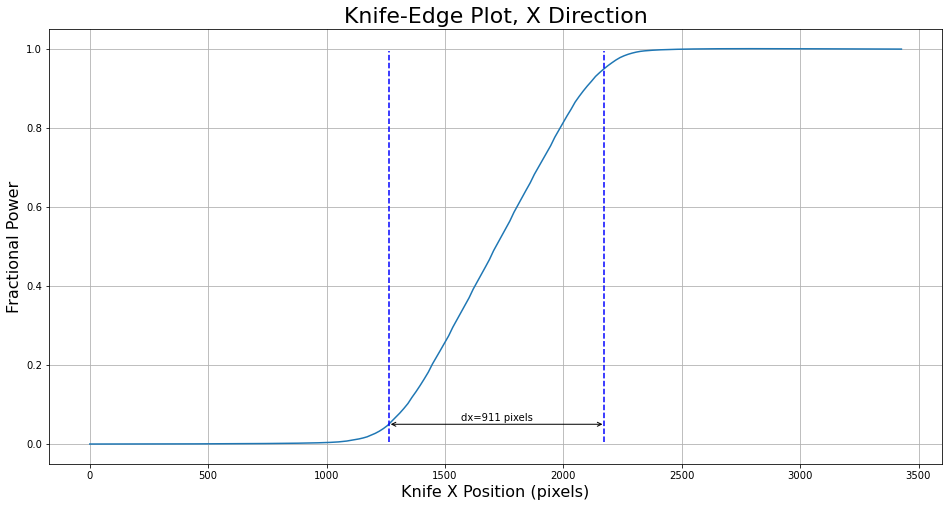

In [5]:
# Load image
img = load_img('nf_100_1234.bmp')

# Subtract background
wimg = lbs.subtract_iso_background(img)

# Mask beam
mask = lbs.rotated_rect_mask(wimg, x, y, dx, dy, phi)

# Working image
mwimg = np.copy(wimg)

# Apply mask
mwimg[mask < 0] = 0

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create array
x_axis = np.linspace(0,1,200)
y_axis = np.full_like(x_axis, 0.0)

# Start time
time1 = time.time()

# Knife edge direction
dir = 'x'

# Collect knife-edge data
for i, x_val in enumerate(x_axis):
    mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = dir)
    masked_image = np.copy(mwimg)
    masked_image[mask < 1] = 0
    y_axis[i] = np.sum(masked_image)

# Normalize knife edge
y_axis = y_axis/np.max(y_axis)

# End time
time2 = time.time()

# Plotting
# -------------------------------------------------------------------------------------------- #

# Convert x axis to pixels
x_axis_p = x_axis * dy * 3

plt.figure(2, figsize=(16,8))
plt.title("Knife-Edge Plot, X Direction", fontsize = 22)
plt.xlabel("Knife X Position (pixels)", fontsize=16)
plt.ylabel("Fractional Power", fontsize = 16)
plt.plot(x_axis_p, y_axis)
plt.grid('on')

# Print time information
print("Took {:.3f} seconds to run measurement with {} points".format(time2-time1, len(x_axis)))

# Find beam width using 5-95 knife-edge measurement
ke1 = 0.05
ke2 = 0.95

# Interpolate values
bws = np.interp([ke1, ke2], y_axis, x_axis_p)

print("Beam widths:")
print(bws)
print(bws[1]-bws[0])

# Plot lines
plt.axvline(x=bws[0], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke1*100), ls='--')
plt.axvline(x=bws[1], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke2*100), ls='--')

# Show distance on plot
units = 'pixels'
plt.annotate('', (bws[0], ke1), (bws[1], ke1), arrowprops={'arrowstyle': '<->'})
plt.text(np.average(bws), 1.1 * ke1, 'd%s=%.0f %s' % (dir, bws[1]-bws[0], units), va='bottom', ha='center')

# Show plots
plt.show()

# Knife-edge for a rotated beam

The center of the beam ellipse is at (279, 171)
The ellipse diameter (closest to horizontal) is 140 pixels
The ellipse diameter (closest to   vertical) is 96 pixels
The ellipse is rotated 30° ccw from the horizontal


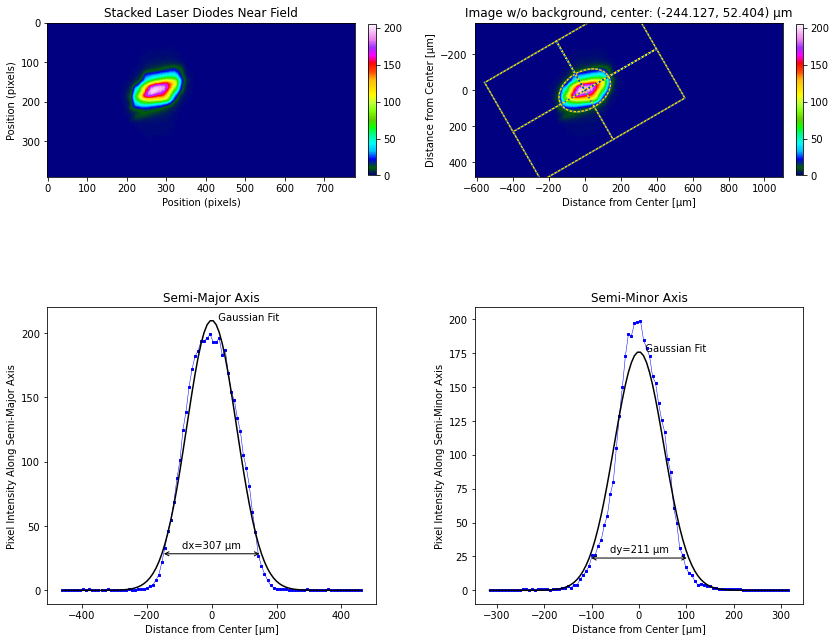

In [6]:
import sys
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Import from this directory so we can rapidly test
sys.path.append('../') # Needed for import
import laserbeamtools as lbs

def load_img(file, folder = r'../tests/test_beam_profiles/DAS'):
    """ Load an image into an array """
    full_path = folder + '/' + file
    if os.path.isfile(full_path):
        iobj = Image.open(full_path)
        img = np.asarray(iobj)
        return img
    else:
        print("No file found under:")
        print(full_path)
        return None

img = load_img('ff_100_1234.bmp')

crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)

img = img[vd:(vv-vd), hd:(hh-vd)]

x, y, dx, dy, phi = lbs.beam_size(img)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

lbs.plot_image_analysis(img, pixel_size=2.2, title="Stacked Laser Diodes Near Field")
plt.show()

## Rotated X Knife-Edge

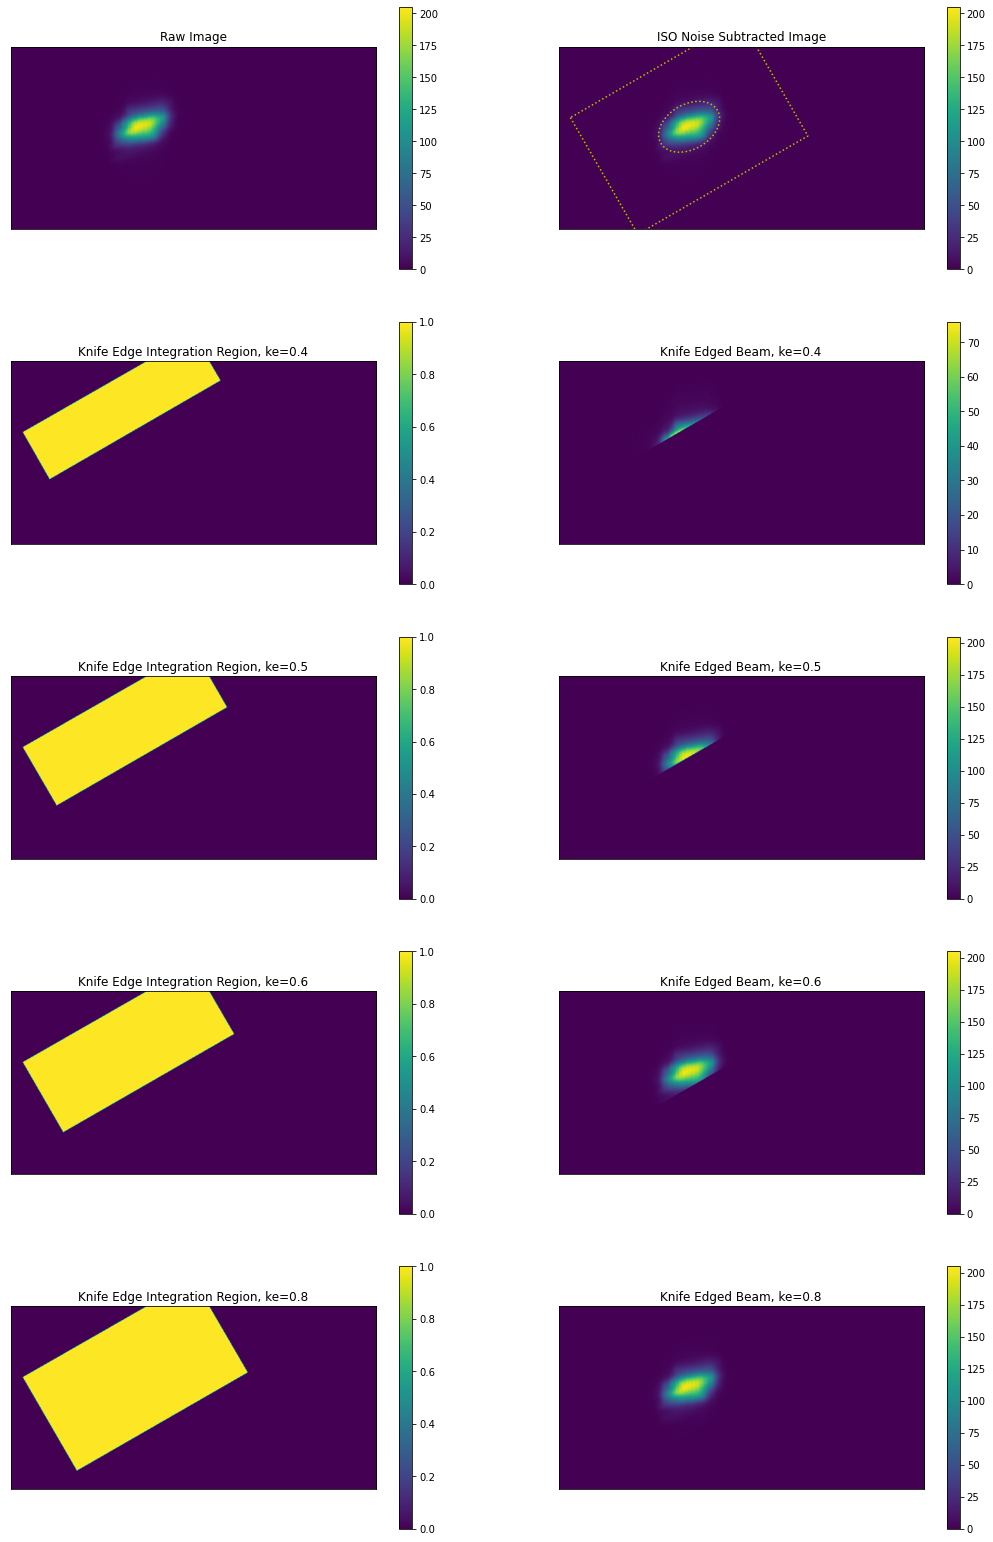

In [7]:

import numpy as np
import time

# Load image
img = load_img('ff_100_1234.bmp')

# Crop parameters
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)

# Crop image
img = img[vd:(vv-vd), hd:(hh-vd)]

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create subplots
plt.subplots(5,2,figsize=(18,28))

# Plot Raw Image
# -------------------------------------------------------------------------------------------- #

plt.subplot(5,2,1)
plt.imshow(img)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('Raw Image')

# Plot ISO Noise Subtracted Image
# -------------------------------------------------------------------------------------------- #

# Create an image with a subtracted background
wimg = lbs.subtract_iso_background(img)

# Generate plots
plt.subplot(5,2,2)
plt.imshow(wimg)
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.title('ISO Noise Subtracted Image')

# Plot masks
xp,yp = lbs.rotated_rect_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

xp,yp = lbs.ellipse_arrays(x, y, dx, dy, phi)
plt.plot(xp,yp,':y')

# Limit plot size
vv, hh = wimg.shape
plt.xlim(0, hh)
plt.ylim(vv, 0)

# Knife Edge ke = 0.25
# -------------------------------------------------------------------------------------------- #

def ke_plot(ke, i):
    """ Method to generate figures for knife edge images """

    plt.subplot(5,2,i)

    mask = lbs.knife_edge_mask(wimg, x, y, dx, dy, phi, ke, dir = 'y')

    plt.imshow(mask)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edge Integration Region, ke={}'.format(ke))

    mwimg= np.copy(wimg)
    mwimg[mask < 1] = 0       # zero all values outside mask

    plt.subplot(5,2,i+1)
    plt.imshow(mwimg)
    plt.colorbar()
    plt.xticks([])
    plt.yticks([])
    plt.title('Knife Edged Beam, ke={}'.format(ke))

# -------------------------------------------------------------------------------------------- #

# Generate knife edge figures
ke_plot(0.4, 3)
ke_plot(0.5, 5)
ke_plot(0.6, 7)
ke_plot(0.8, 9)

Took 0.392 seconds to run measurement with 200 points
Beam widths:
[105.86665612 180.85351379]
74.98685766058566


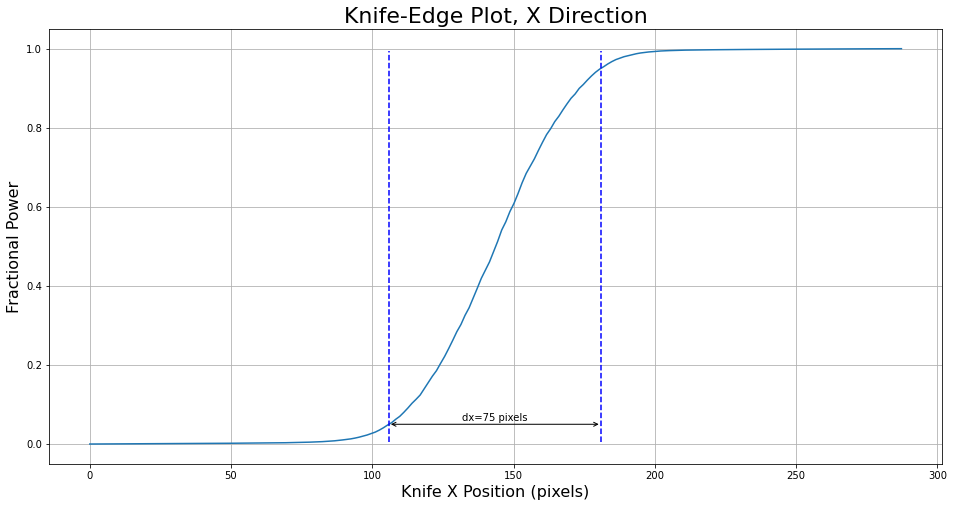

In [8]:
# Load image
img = load_img('ff_100_1234.bmp')

# Crop parameters
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)

# Crop image
img = img[vd:(vv-vd), hd:(hh-vd)]

# Subtract background
wimg = lbs.subtract_iso_background(img)

# Mask beam
mask = lbs.rotated_rect_mask(wimg, x, y, dx, dy, phi)

# Working image
mwimg = np.copy(wimg)

# Apply mask
mwimg[mask < 0] = 0

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create array
x_axis = np.linspace(0,1,200)
y_axis = np.full_like(x_axis, 0.0)

# Start time
time1 = time.time()

# Knife edge direction
dir = 'x'

# Collect knife-edge data
for i, x_val in enumerate(x_axis):
    mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = dir)
    masked_image = np.copy(mwimg)
    masked_image[mask < 1] = 0
    y_axis[i] = np.sum(masked_image)

# Normalize knife edge
y_axis = y_axis/np.max(y_axis)

# End time
time2 = time.time()

# Plotting
# -------------------------------------------------------------------------------------------- #

# Convert x axis to pixels
x_axis_p = x_axis * dy * 3

plt.figure(2, figsize=(16,8))
plt.title("Knife-Edge Plot, {} Direction".format(dir.upper()), fontsize = 22)
plt.xlabel("Knife {} Position (pixels)".format(dir.upper()), fontsize=16)
plt.ylabel("Fractional Power", fontsize = 16)
plt.plot(x_axis_p, y_axis)
plt.grid('on')

# Print time information
print("Took {:.3f} seconds to run measurement with {} points".format(time2-time1, len(x_axis)))

# Find beam width using 5-95 knife-edge measurement
ke1 = 0.05
ke2 = 0.95

# Interpolate values
bws = np.interp([ke1, ke2], y_axis, x_axis_p)

print("Beam widths:")
print(bws)
print(bws[1]-bws[0])

# Plot lines
plt.axvline(x=bws[0], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke1*100), ls='--')
plt.axvline(x=bws[1], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke2*100), ls='--')

# Show distance on plot
units = 'pixels'
plt.annotate('', (bws[0], ke1), (bws[1], ke1), arrowprops={'arrowstyle': '<->'})
plt.text(np.average(bws), 1.1 * ke1, 'd%s=%.0f %s' % (dir, bws[1]-bws[0], units), va='bottom', ha='center')

# Show plots
plt.show()

Took 0.283 seconds to run measurement with 200 points
Beam widths:
[108.78445092 179.68513117]
70.90068024841274


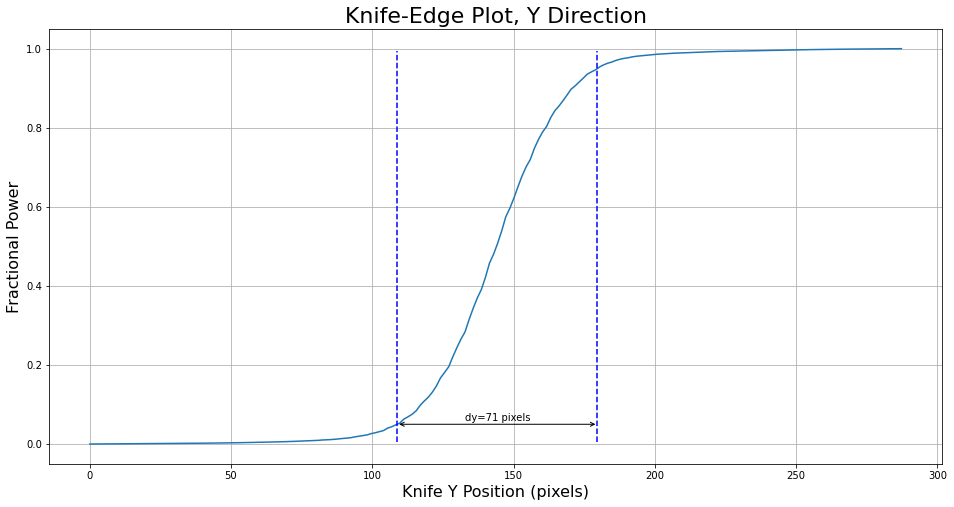

In [9]:
# Load image
img = load_img('ff_100_1234.bmp')

# Crop parameters
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)

# Crop image
img = img[vd:(vv-vd), hd:(hh-hd)]

# Subtract background
wimg = lbs.subtract_iso_background(img)

# Mask beam
mask = lbs.rotated_rect_mask(wimg, x, y, dx, dy, phi)

# Working image
mwimg = np.copy(wimg)

# Apply mask
mwimg[mask < 0] = 0

# Parse Beam
x, y, dx, dy, phi = lbs.beam_size(img)

# Create array
x_axis = np.linspace(0,1,200)
y_axis = np.full_like(x_axis, 0.0)

# Start time
time1 = time.time()

# Knife edge direction
dir = 'y'

# Collect knife-edge data
for i, x_val in enumerate(x_axis):
    mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = dir)
    masked_image = np.copy(mwimg)
    masked_image[mask < 1] = 0
    y_axis[i] = np.sum(masked_image)

# Normalize knife edge
y_axis = y_axis/np.max(y_axis)

# End time
time2 = time.time()

# Plotting
# -------------------------------------------------------------------------------------------- #

# Convert x axis to pixels
x_axis_p = x_axis * dy * 3

plt.figure(2, figsize=(16,8))
plt.title("Knife-Edge Plot, {} Direction".format(dir.upper()), fontsize = 22)
plt.xlabel("Knife {} Position (pixels)".format(dir.upper()), fontsize=16)
plt.ylabel("Fractional Power", fontsize = 16)
plt.plot(x_axis_p, y_axis)
plt.grid('on')

# Print time information
print("Took {:.3f} seconds to run measurement with {} points".format(time2-time1, len(x_axis)))

# Find beam width using 5-95 knife-edge measurement
ke1 = 0.05
ke2 = 0.95

# Interpolate values
bws = np.interp([ke1, ke2], y_axis, x_axis_p)

print("Beam widths:")
print(bws)
print(bws[1]-bws[0])

# Plot lines
plt.axvline(x=bws[0], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke1*100), ls='--')
plt.axvline(x=bws[1], ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke2*100), ls='--')

# Show distance on plot
units = 'pixels'
plt.annotate('', (bws[0], ke1), (bws[1], ke1), arrowprops={'arrowstyle': '<->'})
plt.text(np.average(bws), 1.1 * ke1, 'd%s=%.0f %s' % (dir, bws[1]-bws[0], units), va='bottom', ha='center')

# Show plots
plt.show()

# Function For Plotting X and Y Knife-Edges

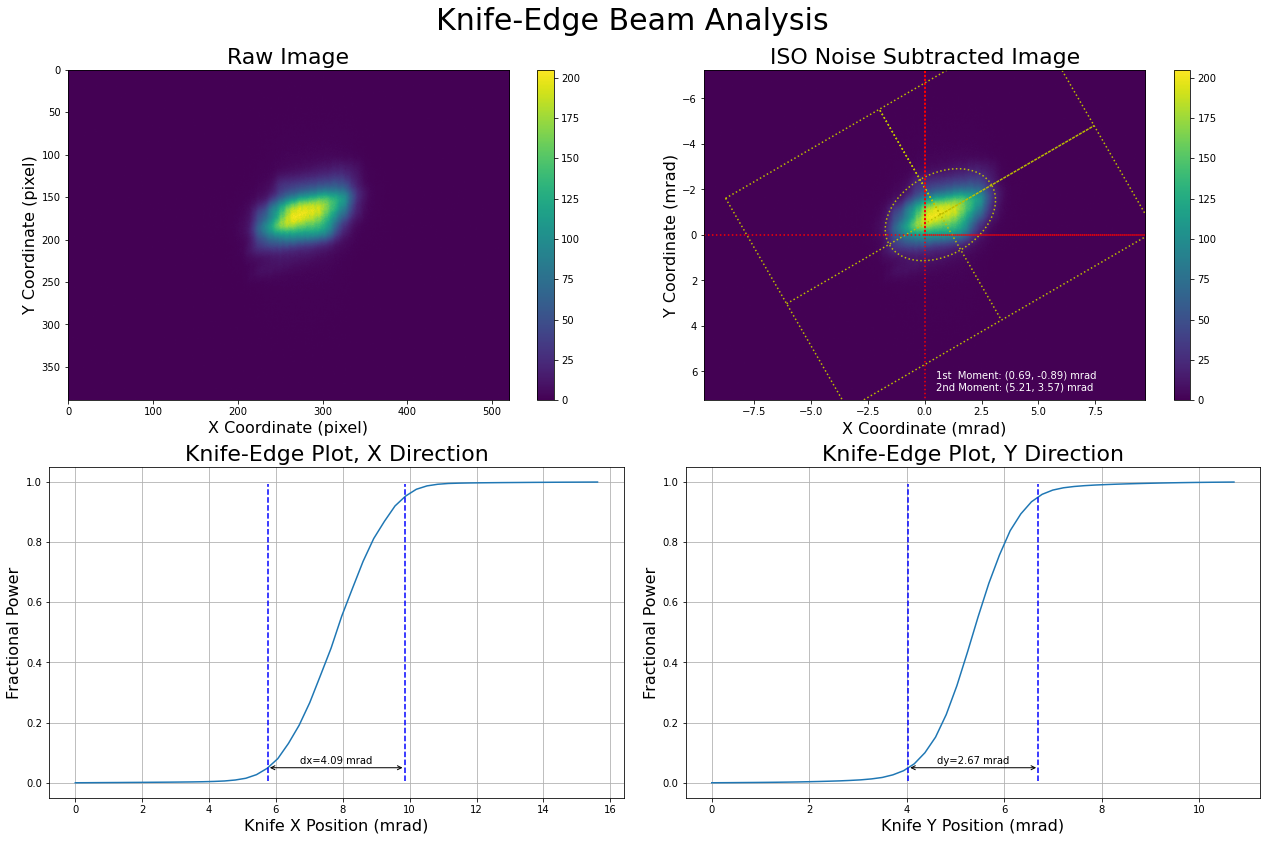

In [91]:
# Input image
img = load_img('ff_100_1234.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

# -------------------------------------------------------------------- #

def plot_knife_edge_analysis(img, pixel_size=None, units='µm', points = 50, kep=[0.05, 0.95]):
    """
    TODO:
    - Add description
    - Add scaling feature - DONE
    - Report center - DONE
    - Report elipticity

    Args:
        img: noise subtracted image
        pixel_size: (optional) size of pixels
        points: number of knife-edge points
        kep: knife-edge points to measure beam from
    Returns:
        nothing
    """
    # determine scaling and labels
    if pixel_size is None:
        scale = 1
        unit_str = ''
        units = 'pixels'
        # label = 'Pixels from Center'
    else:
        scale = pixel_size
        unit_str = '[%s]' % units
        # label = 'Distance from Center %s' % unit_str
    
    # Parse beam
    x, y, dx, dy, phi = lbs.beam_size(img)

    # scale all the dimensions to units of interest
    vv,hh = img.shape
    v_s = vv * scale
    h_s = hh * scale
    x_s = x * scale
    y_s = y * scale
    dx_s = dx * scale
    dy_s = dy * scale

    # Subtract background
    wimg = lbs.subtract_iso_background(img)

    # Mask beam
    mask = lbs.rotated_rect_mask(wimg, x, y, dx, dy, phi)
    
    # Working image
    mwimg = np.copy(wimg)
    
    # Apply mask
    mwimg[mask < 0] = 0
    
    # Knife edge math
    # --------------------------------------------------------------------------------------------------- #

    # Create arrays for x axis
    x_scan_x_axis = np.linspace(0,1,points)
    x_scan_y_axis = np.full_like(x_scan_x_axis, 0.0)
    
    # Create arrays for y axis
    y_scan_x_axis = np.linspace(0,1,points)
    y_scan_y_axis = np.full_like(x_scan_x_axis, 0.0)

    # Collect knife-edge data for x scan
    for i, x_val in enumerate(x_scan_x_axis):
        mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = 'x')
        x_scan_y_axis[i] = np.sum(wimg * mask)
        # masked_image = np.copy(mwimg)
        # masked_image[mask < 1] = 0
        # x_scan_y_axis[i] = np.sum(masked_image) # np.dot(mwing, mask)

    # Normalize knife edge
    x_scan_y_axis = x_scan_y_axis/np.max(x_scan_y_axis)
    
    # Collect knife-edge data for y scan
    for i, x_val in enumerate(y_scan_x_axis):
        mask = lbs.knife_edge_mask(mwimg, x, y, dx, dy, phi, x_val, dir = 'y')
        y_scan_y_axis[i] = np.sum(wimg * mask)
        # masked_image = np.copy(mwimg)
        # masked_image[mask < 1] = 0
        # y_scan_y_axis[i] = np.sum(masked_image) # np.dot(mwing, mask)

    # Normalize knife edge
    y_scan_y_axis = y_scan_y_axis/np.max(y_scan_y_axis)

    # plotting
    # --------------------------------------------------------------------------------------------------- #

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(18, 12))
    
    fig.suptitle("Knife-Edge Beam Analysis", fontsize=30)

    # --------------------------------------------------------------------------------------------------- #

    # Plot 1
    # axs[0,0].subplot(2, 2, 1)
    im = axs[0,0].imshow(img) #, cmap='gist_ncar')
    plt.colorbar(im, ax=axs[0,0])
    axs[0,0].set_title('Raw Image', fontsize=22)
    axs[0,0].set_xlabel("X Coordinate (pixel)", fontsize=16)
    axs[0,0].set_ylabel("Y Coordinate (pixel)", fontsize=16)
    # fig.colorbar(img, ax=[0,0])

    # Plot 2
    extent = np.array([-h_s/2, h_s/2, v_s/2, -v_s/2])
    axs[0,1].imshow(mwimg, extent=extent) #, cmap='gist_ncar')
    plt.colorbar(im, ax=axs[0,1])
    axs[0,1].set_title('ISO Noise Subtracted Image', fontsize=22)

    # Plot masks
    xp,yp = lbs.rotated_rect_arrays(x, y, dx, dy, phi) * scale
    axs[0,1].plot(xp-h_s/2,yp-v_s/2,':y')

    xp,yp = lbs.ellipse_arrays(x, y, dx, dy, phi) * scale
    axs[0,1].plot(xp-h_s/2,yp-v_s/2,':y')


    xp, yp = lbs.axes_arrays(x, y, dx, dy, phi) * scale
    axs[0,1].plot(xp-h_s/2,yp-v_s/2,':y')

    # Center Crosshairs
    xp, yp = lbs.axes_arrays(hh/2, vv/2, hh/3, vv/3, 0) * scale
    axs[0,1].plot(xp-h_s/2,yp-v_s/2,':r')#,linewidth=1)

    # Limit plot size
    #vv, hh = wimg.shape
    axs[0,1].set_xlim(-h_s/2, h_s/2)
    axs[0,1].set_ylim(v_s/2, -v_s/2)
    axs[0,1].set_xlabel("X Coordinate (%s)" % units, fontsize=16)
    axs[0,1].set_ylabel("Y Coordinate (%s)" % units, fontsize=16)
    # axs[0,1].annotate('', (0, 0), (x_s - h_s/2, y_s - v_s/2), arrowprops={'arrowstyle': '<->'})
    m1 = '1st  Moment: (%.2f, %.2f) %s' % (x*scale - h_s/2, y*scale - v_s/2, units)
    m2 = '2nd Moment: (%.2f, %.2f) %s' % (dx_s, dy_s, units)
    axs[0,1].text(h_s/2*0.05, v_s/2*0.95, '\n'.join([m1,m2]), va='bottom', ha='left',c='white',fontsize=10)
    
    # Knife edge plots
    # --------------------------------------------------------------------------------------------------- #

    # Convert x axis to pixels
    x_scan_x_axis_p = x_scan_x_axis * dx * 3

    # Interpolate values
    bws = np.interp([kep[0], kep[1]], x_scan_y_axis, x_scan_x_axis_p)

    axs[1,0].set_title("Knife-Edge Plot, X Direction", fontsize=22)
    axs[1,0].set_xlabel("Knife X Position (%s)" % units, fontsize=16)
    axs[1,0].set_ylabel("Fractional Power", fontsize = 16)
    axs[1,0].plot(x_scan_x_axis_p * scale, x_scan_y_axis)
    axs[1,0].grid('on')
    
    # Plot lines
    axs[1,0].axvline(x=bws[0] * scale, ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(kep[0]*100), ls='--')
    axs[1,0].axvline(x=bws[1] * scale, ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(kep[1]*100), ls='--')

    # Show distance on plot
    axs[1,0].annotate('', (bws[0] * scale, kep[0]), (bws[1] * scale, kep[0]), arrowprops={'arrowstyle': '<->'})
    axs[1,0].text(np.average(bws) * scale, 1.1 * ke1, 'dx=%.2f %s' % ((bws[1]-bws[0]) * scale, units), va='bottom', ha='center')
    
    # Knife edge plots
    # --------------------------------------------------------------------------------------------------- #

    # Convert x axis to pixels
    y_scan_x_axis_p = y_scan_x_axis * dy * 3

    # Interpolate values
    bws = np.interp([kep[0], kep[1]], y_scan_y_axis, y_scan_x_axis_p)

    axs[1,1].set_title("Knife-Edge Plot, Y Direction", fontsize=22)
    axs[1,1].set_xlabel("Knife Y Position (%s)" % units, fontsize=16)
    axs[1,1].set_ylabel("Fractional Power", fontsize = 16)
    axs[1,1].plot(y_scan_x_axis_p * scale, y_scan_y_axis)
    axs[1,1].grid('on')

    # Plot lines
    axs[1,1].axvline(x=bws[0] * scale, ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke1*100), ls='--')
    axs[1,1].axvline(x=bws[1] * scale, ymin=0.05, ymax=0.95, color='b', label='{:.0f}% Point'.format(ke2*100), ls='--')

    # Show distance on plot
    axs[1,1].annotate('', (bws[0] * scale, kep[0]), (bws[1] * scale, kep[0]), arrowprops={'arrowstyle': '<->'})
    axs[1,1].text(np.average(bws) * scale, 1.1 * kep[0], 'dy=%.2f %s' % ((bws[1]-bws[0]) * scale, units), va='bottom', ha='center')

    fig.tight_layout(pad=2)

    plt.show()

    return

psize = 2.2/59

plot_knife_edge_analysis(img, pixel_size=psize, units='mrad')

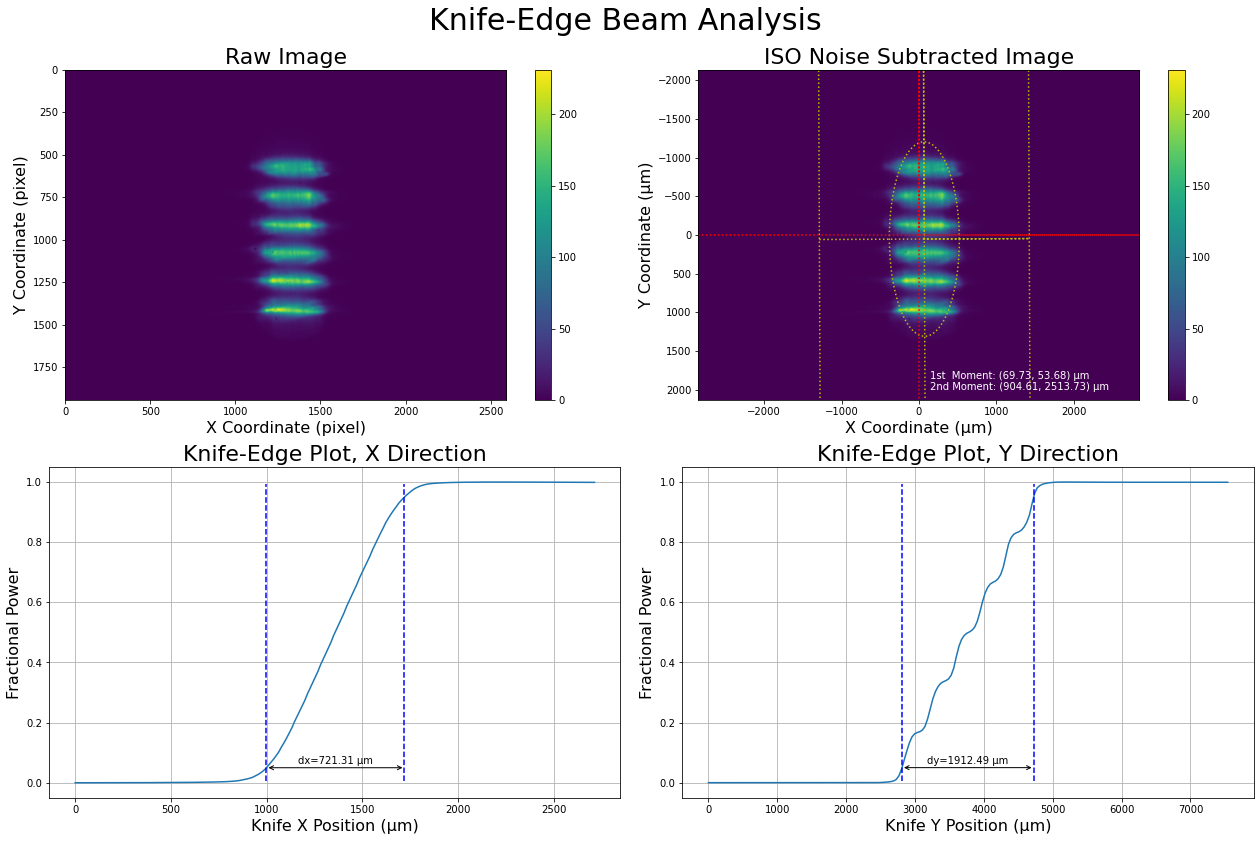

In [99]:
img = load_img('nf_100_1234.bmp')
plot_knife_edge_analysis(img, pixel_size=2.2, points=200)


# Speed Tests

In [95]:
import time

img = load_img('nf_100_1234.bmp')

t1 = time.time()
x, y, dx, dy, phi = lbs.beam_size(img)
t2 = time.time()
print(t2-t1)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))


t1 = time.time()
x, y, dx, dy, phi = lbs.basic_beam_size(img)
t2 = time.time()
print(t2-t1)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

0.4667515754699707
The center of the beam ellipse is at (1328, 996)
The ellipse diameter (closest to horizontal) is 411 pixels
The ellipse diameter (closest to   vertical) is 1143 pixels
The ellipse is rotated 0° ccw from the horizontal
0.026927947998046875
The center of the beam ellipse is at (1321, 995)
The ellipse diameter (closest to horizontal) is 697 pixels
The ellipse diameter (closest to   vertical) is 1203 pixels
The ellipse is rotated 1° ccw from the horizontal


In [98]:
img = load_img('ff_100_1234.bmp')
crop_frac = 0.4
vv,hh = img.shape
vd = int(vv * crop_frac)
hd = int(hh * crop_frac)
img = img[vd:(vv-vd), hd:(hh-hd)]

t1 = time.time()
x, y, dx, dy, phi = lbs.beam_size(img)
t2 = time.time()
print(t2-t1)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))


t1 = time.time()
x, y, dx, dy, phi = lbs.basic_beam_size(img)
t2 = time.time()
print(t2-t1)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x, y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from the horizontal" % (phi * 180/3.1416))

0.02593088150024414
The center of the beam ellipse is at (279, 171)
The ellipse diameter (closest to horizontal) is 140 pixels
The ellipse diameter (closest to   vertical) is 96 pixels
The ellipse is rotated 30° ccw from the horizontal
0.0009975433349609375
The center of the beam ellipse is at (278, 172)
The ellipse diameter (closest to horizontal) is 150 pixels
The ellipse diameter (closest to   vertical) is 110 pixels
The ellipse is rotated 25° ccw from the horizontal
